## In-built Library Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data Visualization and Cleaning

We visualize what our dataset looks like. We will make use of one-hot encoding so that we can properly factor in categorical data in the clustering algorithm.

In [2]:
#visualize the original dataset, then drop anything that might not be relevant to the clustering
eatingHabits = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
eatingHabits = eatingHabits[['Gender','Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']]
eatingHabits.head()

,Gender,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,Female,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0
1,Female,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0
2,Male,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0
3,Male,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0
4,Male,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0


In [3]:
#use pd.dummies to get one-hot encoded version of dataset
#check columns to see if we one-hot encoded correctly
eatingHabits = pd.get_dummies(eatingHabits)
eatingHabits.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male'],
      dtype='object')

In [4]:
#understand the shape of the dataset -- there are 38 columns because some non-categorical variables 
#are one-hot encoded
eatingHabits.shape

(2111, 10)

In [5]:
#we check the dataset for empty data, and if there are, we remove it
eatingHabits.isnull().values.any()

False

## K-means Clustering (Model Building)

In [6]:
#first, we zero-mean the data so the data has a mean of 0 and a standard deviation of 1
#NOTE: we do not scale the gender columns as they are categorical
scaler = StandardScaler()
eatingData = scaler.fit_transform(eatingHabits[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']])
#we then concatenate the previous gender columns to what we already have
eatingData = np.concatenate((eatingData, eatingHabits[['Gender_Female', 'Gender_Male']].to_numpy()), axis=1)
eatingData.shape

(2111, 10)

In [7]:
#now we create the kmeans model -- we do this in a function so that we can
#create models that result in different numbers of clusters
def createKMeans(data,cluster_num):
    #initialize the KMeans centroids and number of clusters
    kmeans = KMeans(init='random', n_clusters=cluster_num, random_state=9)
    
    #return the model
    return kmeans

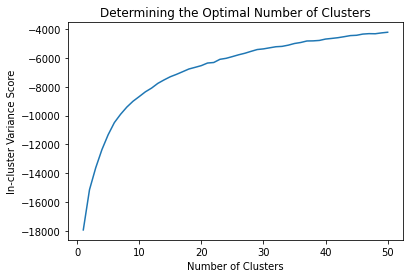

In [8]:
#now that we have the KMeans function, we run it to create the model for different numbers
#of clusters and look at the score to determine which cluster is the best
scores = []

for num in range(1,51):
    kmeans = createKMeans(eatingData, num)
    #fit the data to the model
    kmeans.fit(eatingData)
    #get the score of the data which was fitted to the model and append to scores
    scores.append(kmeans.score(eatingData))

#now we plot the scores and use the elbow rule to check how many clusters is optimal for clustering
plt.plot(range(1,51), scores)
plt.title('Determining the Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('In-cluster Variance Score')
plt.show()

Looking at the curve, we determined that using that around 5-10 clusters would be good for clustering as the variance startes flattening out as the number of clusters go past 10.

In [9]:
kmeans_model = createKMeans(eatingData, 5)
#fit the data to the model
kmeans_model.fit(eatingData)
#get the cluster membership for the data
cluster = kmeans_model.predict(eatingData)

## K-mean Clustering (PCA & Visualization)

Since we have 10 features in our dataset, we need to conduct PCA on the data and project it onto two components so that we can plot our clusters.

In [10]:
#create a pca
pca = PCA(n_components=2)
#fit the data to the pca
pca.fit(eatingData)
#put data into the PCA space with 2 components
eatingData_reduced = pca.transform(eatingData)
#confirm the shape - should be the number of data samples X the component space
eatingData_reduced.shape

(2111, 2)

In [11]:
#we fit the centroids of each cluster into pca space as well
centroids_reduced = pca.transform(kmeans_model.cluster_centers_)
#confirm the shape, should be number of clusters X pca component space
centroids_reduced.shape

(5, 2)

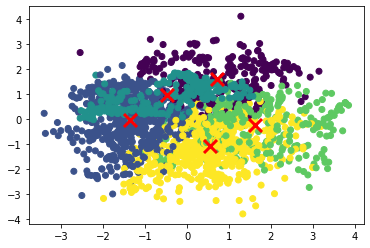

In [12]:
#visualize the clustered data and their centroids
fig, ax = plt.subplots()
clusterPlot = ax.scatter(eatingData_reduced[:,0], eatingData_reduced[:,1], c=cluster, cmap = 'viridis')
ax.scatter(centroids_reduced[:,0], centroids_reduced[:,1], marker='x', s=169, linewidths=3,color='red')
plt.show()

## K-means Clustering (Analysis)

We will analyze the clusters based on various calculations.

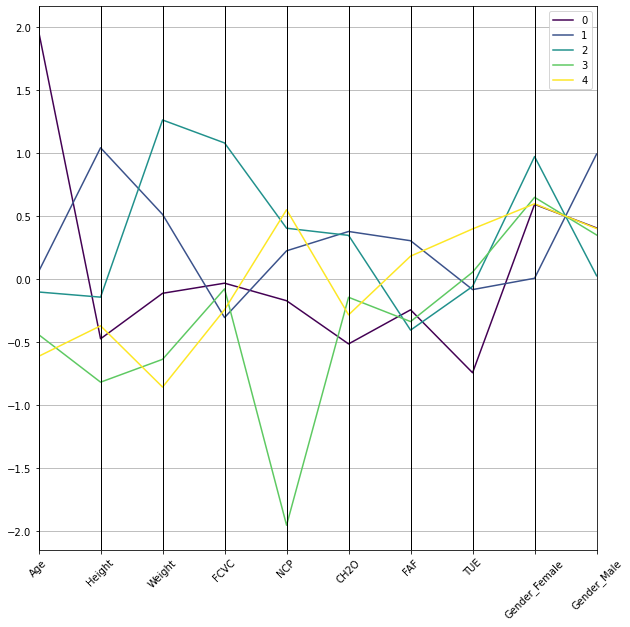

In [13]:
#create dataframe based on centroids
centroids = pd.DataFrame(kmeans_model.cluster_centers_, columns = eatingHabits.columns)
centroids['Cluster'] = centroids.index
#plot the parallel coordinates to see analyze clusters
plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
pd.plotting.parallel_coordinates(centroids, class_column = 'Cluster', colormap='viridis')
plt.show()

We have partitioned our data of eating habits into 5 clusters. To determine how these clusters were formed, we analyze the parallel coordinate plot from the pandas library.
1. For cluster 0, the purple cluster, we notice that this cluster was formed based on a high proportion of age and females. <br>
2. For cluster 1, the blue cluster, there is a high proportion of males and height. <br>
3. For cluster 2, the teal cluster, we see that there is a high proportion of female and weight <br>
4. For cluster 3, the green cluster, we see low NCP and high rankings for FCVC. There is also a greater proportion of females. <br>
5. For cluster 4, the yellow cluster, we see high proportions of females and NCP. <br>
<br>

In [14]:
eatingData_df = pd.DataFrame(eatingData, columns = eatingHabits.columns)
eatingData_df['Cluster'] = cluster

In [15]:
def maxdistfromcentroid(cluster, centroid):
    max_dist = 0
    for data in cluster:
        temp = np.linalg.norm(data-centroid)
        if temp > max_dist:
            max_dist = temp
    return max_dist

In [16]:
def avgdistfromcentroid(cluster, centroid):
    avg_dist = 0
    for data in cluster:
        avg_dist += np.linalg.norm(data-centroid)
    return avg_dist/len(cluster)

In [17]:
for i in range(5):
    cluster_ = eatingData_df[eatingData_df['Cluster'] == i].drop(columns = ['Cluster']).to_numpy()
    centroid_ = kmeans_model.cluster_centers_[i]
    max_distance = maxdistfromcentroid(cluster_, centroid_)
    avg_distance = avgdistfromcentroid(cluster_, centroid_)
    print('Cluster', i)
    print('Centroid', str(i+1) + ':', centroid_)
    print('Number of observations:', len(cluster_))
    print('Maximum distance from centroid:', max_distance)
    print('Average distance from centroid:', avg_distance)
    print()

Cluster 0
Centroid 1: [ 1.97054176 -0.47426073 -0.11276945 -0.032497   -0.17172933 -0.51486148
 -0.24409226 -0.74389327  0.59375     0.40625   ]
Number of observations: 256
Maximum distance from centroid: 5.168246108982701
Average distance from centroid: 2.394331622570507

Cluster 1
Centroid 2: [ 0.05912637  1.04344179  0.51361939 -0.3054928   0.2247369   0.37825849
  0.30487472 -0.08341364  0.00655738  0.99344262]
Number of observations: 610
Maximum distance from centroid: 4.160046797828291
Average distance from centroid: 2.224574383386577

Cluster 2
Centroid 3: [-0.10249783 -0.14342319  1.26400701  1.08144661  0.40415272  0.34732841
 -0.40541371 -0.05836476  0.97345133  0.02654867]
Number of observations: 339
Maximum distance from centroid: 3.6150385458284457
Average distance from centroid: 1.7110953887568607

Cluster 3
Centroid 4: [-0.44063591 -0.81879031 -0.63734283 -0.0775098  -1.95523468 -0.14449032
 -0.33747064  0.05484321  0.64948454  0.35051546]
Number of observations: 292
Max

Cluster 2, which is the teal cluster, seems to have the least variability. However, this may be due to the lesser amount of observations. Cluster 3, which is the green cluster, has the highest variability.